In [1]:
import matplotlib.pyplot as plt
import numpy as np

print(plt.style.available)
from pytdscf.util import read_nc
from pytdscf import units

plt.style.use("bmh")

# Make all new figures/axes transparent by default
plt.rcParams["figure.facecolor"] = "none"  # or (1, 1, 1, 0)
plt.rcParams["axes.facecolor"] = "none"

plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Latin Modern Roman"],
        "mathtext.fontset": "cm",  # still fine; there is no LMR math in mathtext
    }
)
plt.rcParams.update(
    {
        "text.usetex": True,
        # Tell LaTeX to load any package you like
        "text.latex.preamble": r"\usepackage{amssymb}",
    }
)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [2]:
from scipy.interpolate import CubicSpline  # step 1


def cumulative_population(t, p):
    """
    Parameters
    ----------
    t : (N,) 1‑D array, strictly increasing time points
    p : (N,) 1‑D array, population values at each t[i]

    Returns
    -------
    F : (N,) array
        Cumulative population  ∫₀^{t[i]} f(t') dt'  for every i
    f : callable
        The fitted cubic‑spline function so you can evaluate it anywhere
    """
    # --- 1. fit (t, p) with a *natural* cubic spline (interpolant, no smoothing)
    f = CubicSpline(t, p, bc_type="natural")  # C²‑continuous, exact at data points

    # --- 2. form its antiderivative once, then evaluate at all τ = t[i]
    F_int = f.antiderivative()  # analytic Quartic‑spline
    F = F_int(t) - F_int(t[0])  # cumulative integral from t[0]=0

    return F

In [3]:
import netCDF4 as nc

for variable in nc.Dataset(
    "theta/aiso_chi1024_cutoff0.1_C_B0.05_angle0pi_over_8_prop/reduced_density.nc", "r", format="NETCDF4"
).variables:
    print(variable)

time
rho_(16,)_0


In [4]:
nsinv = r"$\mathrm{ns}^{-1}$"
mT = r"\;\mathrm{mT}"
directions = ["x", "y", "z"]
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]  # [:3]

m = 1024
# p25 in SI of Nature 2021
kr_dict = {(0, 1): 1.7e07, (0, 2): 0.0}  # recombination
kf_dict = {(0, 1): 5.7e06, (0, 2): 1.0e07}  # fuluorecence

# table S3
# BC 5.0e+10
# CB 9.0e+05
kDC = 1.3e10  # 1.3e+10
kCD = 1.5e10  # 1.5e+10

B0 = 0.050  # 2.0  # Typically 0.01 mT~10 mT
SCALE = 1.0e-09


def get_time_dm(m, angle, cutoff, ele_site, ele_site_C, ele_site_D):
    B = 0.05
    jobname_eq = f"theta/aiso_chi{m}_cutoff{cutoff}_eq_B{B}_angle{angle}pi_over_8_n4_arnoldi_prop"
    jobname_C  = f"theta/aiso_chi{m}_cutoff{cutoff}_C_B{B}_angle{angle}pi_over_8_prop"
    jobname_D  = f"theta/aiso_chi{m}_cutoff{cutoff}_D_B{B}_angle{angle}pi_over_8_prop"

    try:
        data_eq = read_nc(f"{jobname_eq}/reduced_density.nc", [(ele_site, )])
        data_C = read_nc(f"{jobname_C}/reduced_density.nc", [(ele_site_C, )])
        data_D = read_nc(f"{jobname_D}/reduced_density.nc", [(ele_site_D, )])
    except FileNotFoundError:
        raise
    time_data_μs_eq = data_eq["time"] * SCALE * 1e06 / units.au_in_fs
    dm_eq = data_eq[(ele_site,)]
    time_data_μs_C = data_C["time"] * SCALE * 1e06 / units.au_in_fs
    dm_C = data_C[(ele_site_C,)]
    dm_D = data_D[(ele_site_D,)]
    return time_data_μs_eq, dm_eq, time_data_μs_C, dm_C, dm_D

# For inteval [0, t1], [t1, t2] rather than [0, t1], [0, t2]
def plot_aiso_mfe_dt(
    cutoff,
    ele_site,
    ele_site_C,
    ele_site_D,
    show_xlabel=True,
    show_ylabel=True,
    show_legend=True,
    xlim=None,
    ylim=None,
    dn=3,
):
    """
    figure: 4 subplots [eq(C only), C only, eq(D only), D only]
    x: angle in [0, π/8, ..., π]  (θ)
    y: MFE (%) = (Phi(θ) - Phi_ref) / Phi_ref * 100
    legend: time series (e.g., 30 ns, 60 ns, ..., 390 ns) colored by rainbow gradation
    """
    import matplotlib as mpl
    import numpy as np
    import matplotlib.pyplot as plt

    # angles: 0..8 → 0, π/8, ..., π
    angle_idx = np.arange(0, 9)
    angle_values = angle_idx * (np.pi / 8.0)

    # 1) Gather Φ(t; θ) for each model across all angles (exclude π because = 0)
    phi_eq_C_list, phi_eq_D_list, phi_C_list, phi_D_list = [], [], [], []
    time_data_ref_eq = None
    time_data_ref_CD = None

    for angle in angle_idx[:-1]:
        time_data_μs_eq, dm_eq, time_data_μs_CD, dm_C, dm_D = get_time_dm(
            m, angle, cutoff, ele_site, ele_site_C, ele_site_D
        )
        if time_data_ref_eq is None:
            time_data_ref_eq = time_data_μs_eq  # shared across angles
            time_data_ref_CD = time_data_μs_CD  # shared across angles

        phi_eq_C = cumulative_population(time_data_μs_eq, dm_eq[:, 2].real) * kf_dict[(0, 1)] * 1e-06
        phi_eq_D = cumulative_population(time_data_μs_eq, dm_eq[:, 6].real) * kf_dict[(0, 2)] * 1e-06
        phi_D    = cumulative_population(time_data_μs_CD, dm_D[:, 2].real)  * kf_dict[(0, 2)] * 1e-06

        try:
            phi_C    = cumulative_population(time_data_μs_CD, dm_C[:, 2].real)  * kf_dict[(0, 1)] * 1e-06
        except:
            print(angle, m, cutoff, dm_C, time_data_μs_CD)
        
        phi_eq_C_list.append(phi_eq_C)
        phi_eq_D_list.append(phi_eq_D)
        phi_C_list.append(phi_C)
        phi_D_list.append(phi_D)

    # Stack to arrays: (n_angles, n_time)
    phi_eq_C_arr = np.asarray(phi_eq_C_list)
    phi_eq_D_arr = np.asarray(phi_eq_D_list)
    phi_C_arr    = np.asarray(phi_C_list)
    phi_D_arr    = np.asarray(phi_D_list)

    # 2) Reference (mean over angles), per model
    phi_eq_C_ref = np.mean(phi_eq_C_arr, axis=0)
    phi_eq_D_ref = np.mean(phi_eq_D_arr, axis=0)
    phi_C_ref    = np.mean(phi_C_arr,    axis=0)
    phi_D_ref    = np.mean(phi_D_arr,    axis=0)

    # 3) MFE (%, set t=0 to 0)
    time_idxs_eq = np.arange(4*dn, 4*dn * (50+1), 4*dn)
    time_idxs_CD = np.arange(1*dn, 1*dn * (50+1), 1*dn)

    mfe_eq_C = np.empty((8,len(time_idxs_eq)))
    mfe_eq_D = np.empty((8,len(time_idxs_eq)))
    mfe_C = np.empty((8,len(time_idxs_eq)))
    mfe_D = np.empty((8,len(time_idxs_eq)))
    for j, t_idx2 in enumerate(time_idxs_eq):
        if j == 0:
            mfe_eq_C[:,j] = (phi_eq_C_arr[:, t_idx2] / phi_eq_C_ref[None, t_idx2] - 1.0) * 100.0
            mfe_eq_D[:,j] = (phi_eq_D_arr[:, t_idx2] / phi_eq_D_ref[None, t_idx2] - 1.0) * 100.0
        else:
            mfe_eq_C[:,j] = ((phi_eq_C_arr[:, t_idx2] - phi_eq_C_arr[:, t_idx1]) / (phi_eq_C_ref[None, t_idx2] - phi_eq_C_ref[None, t_idx1]) - 1.0) * 100.0
            mfe_eq_D[:,j] = ((phi_eq_D_arr[:, t_idx2] - phi_eq_D_arr[:, t_idx1]) / (phi_eq_D_ref[None, t_idx2] - phi_eq_D_ref[None, t_idx1]) - 1.0) * 100.0
        t_idx1 = t_idx2
    for j, t_idx2 in enumerate(time_idxs_CD):
        if j == 0:
            mfe_C[:,j] = (phi_C_arr[:, t_idx2] / phi_C_ref[None, t_idx2] - 1.0) * 100.0
            mfe_D[:,j] = (phi_D_arr[:, t_idx2] / phi_D_ref[None, t_idx2] - 1.0) * 100.0
        else:
            mfe_C[:,j] = ((phi_C_arr[:, t_idx2] - phi_C_arr[:, t_idx1]) / (phi_C_ref[None, t_idx2] - phi_C_ref[None, t_idx1]) - 1.0) * 100.0
            mfe_D[:,j] = ((phi_D_arr[:, t_idx2] - phi_D_arr[:, t_idx1]) / (phi_D_ref[None, t_idx2] - phi_D_ref[None, t_idx1]) - 1.0) * 100.0
        t_idx1 = t_idx2
    #for arr in (mfe_eq_C, mfe_eq_D, mfe_C, mfe_D):
    #    arr[:, 0] = 0.0

    # Append angle π row (= angle 0) to close the loop
    mfe_eq_C = np.vstack([mfe_eq_C, mfe_eq_C[0, :]])
    mfe_eq_D = np.vstack([mfe_eq_D, mfe_eq_D[0, :]])
    mfe_C    = np.vstack([mfe_C,    mfe_C[0, :]])
    mfe_D    = np.vstack([mfe_D,    mfe_D[0, :]])

    # 4) Plot: x=θ, legend=time (rainbow gradation)
    plt.clf()
    fig, axs = plt.subplots(2, 2, figsize=(7, 7), sharey=True)
    axs = axs.flatten()

    # time indices for plotting/legend
    #time_idxs_eq = np.arange(4*dn, 4*dn * 11, 4*dn)
    #time_idxs_CD = np.arange(1*dn, 1*dn * 11, 1*dn)
    times_ns_eq = time_data_ref_eq[time_idxs_eq] * 1000.0  # μs → ns
    times_ns_CD = time_data_ref_CD[time_idxs_CD] * 1000.0  # μs → ns

    panels = [
        (mfe_eq_C, r"$S_\mathrm{C}$ (C $\rightleftarrows$ D model)", ":", "o", time_idxs_eq, times_ns_eq),
        (mfe_C,    r"$S_\mathrm{C}$ (C only model)",      ":", "o", time_idxs_CD, times_ns_CD),
        (mfe_eq_D, r"$S_\mathrm{D}$ (C $\rightleftarrows$ D model)", ":", "o", time_idxs_eq, times_ns_eq),
        (mfe_D,    r"$S_\mathrm{D}$ (D only model)",      ":", "o", time_idxs_CD, times_ns_CD),
    ]
    # Rainbow gradation across time
    cmap = plt.get_cmap("rainbow")
    norm = mpl.colors.Normalize(vmin=times_ns_eq.min(), vmax=times_ns_eq.max())
    time_colors = cmap(norm(times_ns_eq))  # one color per time curve

    # θ ticks: 0, π/8, …, π
    if xlim is None:
        xticks = angle_values
        xtick_labels = [r"$0$", r"$\frac{\pi}{8}$",  r"$\frac{\pi}{4}$", r"$\frac{3\pi}{8}$", r"$\frac{\pi}{2}$",
                        r"$\frac{5\pi}{8}$", r"$\frac{3\pi}{4}$", r"$\frac{7\pi}{8}$", r"$\pi$"]

    for ax_i, (ax, (mfe_arr, title, ls, marker, time_idxs, times_ns)) in enumerate(zip(axs, panels)):
        for j, t_idx in enumerate(time_idxs):
            ax.plot(
                angle_values,
                mfe_arr[:, j],
                ls=ls,
                marker=marker,
                color=time_colors[j],
                label=(f"{times_ns[j]:.0f} ns" if ax_i == 0 else None),  # only label in first panel
                markevery=1,
                markersize=4,
            )
        ax.set_title(title, fontsize=13)
        if xlim is None:
            ax.set_xlim(0.0, np.pi)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xtick_labels, fontsize=10)
        else:
            ax.set_xlim(*xlim)
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.grid(ls=":")


    # Legend: right side, single column (use handles from first panel)
    # --- legend (right side) ---
    if show_legend:
        handles, labels = axs[0].get_legend_handles_labels()
        # leave space for legend on the right
        fig.subplots_adjust(left=0.14, bottom=0.16, top=0.88, right=0.78)
        fig.legend(
            handles, labels,
            loc="center left", bbox_to_anchor=(0.80, 0.5),
            ncol=1, fontsize=10, frameon=True,
        )
    else:
        fig.subplots_adjust(left=0.14, bottom=0.16, top=0.88, right=0.95)

    # --- compute grid bbox and place shared labels + tighter title ---
    # need a draw to finalize positions
    fig.canvas.draw()
    bboxes = [ax.get_position() for ax in axs]
    left   = min(bb.x0 for bb in bboxes)
    right  = max(bb.x1 for bb in bboxes)
    bottom = min(bb.y0 for bb in bboxes)
    top    = max(bb.y1 for bb in bboxes)

    grid_x_center = (left + right) / 2.0
    grid_y_center = (bottom + top) / 2.0

    # shared x/y labels centered on the grid area
    if show_xlabel:
        fig.text(grid_x_center, bottom - 0.06, r"azimuthal angle $\theta$ ($\phi=0$)",
                 ha="center", va="top", fontsize=13)
    if show_ylabel:
        fig.text(left - 0.10, grid_y_center,
                 (r"$\mathrm{singlet\;yield\;ratio}\; "
                  r"\frac{\Phi^W(t, \theta)-\Phi_{\mathrm{ref}}^W(t)}{\Phi_{\mathrm{ref}}^W(t)} \times 100\%$"),
                 ha="center", va="center", rotation=90, fontsize=13)

    # move title closer to the grid (just above the top of subplots)
    if cutoff == 0.5:
        Nf, Nc, Nd = 1, 3, 3
    elif cutoff == 0.3:
        Nf, Nc, Nd = 5, 6, 5
    elif cutoff == 0.1:
        Nf, Nc, Nd = 12, 9, 9
    else:
        raise ValueError
    plt.suptitle(r"$\mathrm{cutoff} > " + f"{cutoff} {mT}\\; |B| = 0.05 {mT}$ : \n {Nf} {"nucleus" if Nf==1 else "nuclei"} for FAD, {Nc} nuclei for TrpC, {Nd} nuclei for TrpD",
                 fontsize=14, y=min(top + 0.10, 1.00), x=0.45)

    # no further tight_layout here; we've positioned everything explicitly
    fname = f"phi_cutoff{cutoff}_chi{m}_theta_4subplots.eps"
    plt.savefig(fname, bbox_inches="tight")
    plt.show()


In [5]:
def plot_aiso_mfe(
    cutoff,
    ele_site,
    ele_site_C,
    ele_site_D,
    show_xlabel=True,
    show_ylabel=True,
    show_legend=True,
    xlim=None,
    ylim=None,
    dn=15,
):
    """
    figure: 4 subplots [eq(C only), C only, eq(D only), D only]
    x: angle in [0, π/8, ..., π]  (θ)
    y: MFE (%) = (Phi(θ) - Phi_ref) / Phi_ref * 100
    legend: time series (e.g., 30 ns, 60 ns, ..., 390 ns) colored by rainbow gradation
    """
    import matplotlib as mpl
    import numpy as np
    import matplotlib.pyplot as plt

    # angles: 0..8 → 0, π/8, ..., π
    angle_idx = np.arange(0, 9)
    angle_values = angle_idx * (np.pi / 8.0)

    # 1) Gather Φ(t; θ) for each model across all angles (exclude π because = 0)
    phi_eq_C_list, phi_eq_D_list, phi_C_list, phi_D_list = [], [], [], []
    time_data_ref_eq = None
    time_data_ref_CD = None

    for angle in angle_idx[:-1]:
        time_data_μs_eq, dm_eq, time_data_μs_CD, dm_C, dm_D = get_time_dm(
            m, angle, cutoff, ele_site, ele_site_C, ele_site_D
        )
        if time_data_ref_eq is None:
            time_data_ref_eq = time_data_μs_eq  # shared across angles
            time_data_ref_CD = time_data_μs_CD  # shared across angles

        phi_eq_C = cumulative_population(time_data_μs_eq, dm_eq[:, 2].real) * kf_dict[(0, 1)] * 1e-06
        phi_eq_D = cumulative_population(time_data_μs_eq, dm_eq[:, 6].real) * kf_dict[(0, 2)] * 1e-06
        phi_D    = cumulative_population(time_data_μs_CD, dm_D[:, 2].real)  * kf_dict[(0, 2)] * 1e-06

        try:
            phi_C    = cumulative_population(time_data_μs_CD, dm_C[:, 2].real)  * kf_dict[(0, 1)] * 1e-06
        except:
            print(angle, m, cutoff, dm_C, time_data_μs_CD)
        
        phi_eq_C_list.append(phi_eq_C)
        phi_eq_D_list.append(phi_eq_D)
        phi_C_list.append(phi_C)
        phi_D_list.append(phi_D)

    # Stack to arrays: (n_angles, n_time)
    phi_eq_C_arr = np.asarray(phi_eq_C_list)
    phi_eq_D_arr = np.asarray(phi_eq_D_list)
    phi_C_arr    = np.asarray(phi_C_list)
    phi_D_arr    = np.asarray(phi_D_list)

    # 2) Reference (mean over angles), per model
    phi_eq_C_ref = np.mean(phi_eq_C_arr, axis=0)
    phi_eq_D_ref = np.mean(phi_eq_D_arr, axis=0)
    phi_C_ref    = np.mean(phi_C_arr,    axis=0)
    phi_D_ref    = np.mean(phi_D_arr,    axis=0)

    # 3) MFE (%, set t=0 to 0)
    mfe_eq_C = (phi_eq_C_arr / phi_eq_C_ref[None, :] - 1.0) * 100.0
    mfe_eq_D = (phi_eq_D_arr / phi_eq_D_ref[None, :] - 1.0) * 100.0
    mfe_C    = (phi_C_arr    / phi_C_ref[None, :]    - 1.0) * 100.0
    mfe_D    = (phi_D_arr    / phi_D_ref[None, :]    - 1.0) * 100.0
    for arr in (mfe_eq_C, mfe_eq_D, mfe_C, mfe_D):
        arr[:, 0] = 0.0

    # Append angle π row (= angle 0) to close the loop
    mfe_eq_C = np.vstack([mfe_eq_C, mfe_eq_C[0, :]])
    mfe_eq_D = np.vstack([mfe_eq_D, mfe_eq_D[0, :]])
    mfe_C    = np.vstack([mfe_C,    mfe_C[0, :]])
    mfe_D    = np.vstack([mfe_D,    mfe_D[0, :]])

    # 4) Plot: x=θ, legend=time (rainbow gradation)
    plt.clf()
    fig, axs = plt.subplots(2, 2, figsize=(7, 7), sharey=True)
    axs = axs.flatten()

    # time indices for plotting/legend
    time_idxs_eq = np.arange(4*dn, 4*dn * 11, 4*dn)
    time_idxs_CD = np.arange(1*dn, 1*dn * 11, 1*dn)
    times_ns_eq = time_data_ref_eq[time_idxs_eq] * 1000.0  # μs → ns
    times_ns_CD = time_data_ref_CD[time_idxs_CD] * 1000.0  # μs → ns

    panels = [
        (mfe_eq_C, r"$S_\mathrm{C}$ (C $\rightleftarrows$ D model)", ":", "o", time_idxs_eq, times_ns_eq),
        (mfe_C,    r"$S_\mathrm{C}$ (C only model)",      ":", "o", time_idxs_CD, times_ns_CD),
        (mfe_eq_D, r"$S_\mathrm{D}$ (C $\rightleftarrows$ D model)", ":", "o", time_idxs_eq, times_ns_eq),
        (mfe_D,    r"$S_\mathrm{D}$ (D only model)",      ":", "o", time_idxs_CD, times_ns_CD),
    ]
    # Rainbow gradation across time
    cmap = plt.get_cmap("rainbow")
    norm = mpl.colors.Normalize(vmin=times_ns_eq.min(), vmax=times_ns_eq.max())
    time_colors = cmap(norm(times_ns_eq))  # one color per time curve

    # θ ticks: 0, π/8, …, π
    if xlim is None:
        xticks = angle_values
        xtick_labels = [r"$0$", r"$\frac{\pi}{8}$",  r"$\frac{\pi}{4}$", r"$\frac{3\pi}{8}$", r"$\frac{\pi}{2}$",
                        r"$\frac{5\pi}{8}$", r"$\frac{3\pi}{4}$", r"$\frac{7\pi}{8}$", r"$\pi$"]

    for ax_i, (ax, (mfe_arr, title, ls, marker, time_idxs, times_ns)) in enumerate(zip(axs, panels)):
        for j, t_idx in enumerate(time_idxs):
            ax.plot(
                angle_values,
                mfe_arr[:, t_idx],
                ls=ls,
                marker=marker,
                color=time_colors[j],
                label=(f"{times_ns[j]:.0f} ns" if ax_i == 0 else None),  # only label in first panel
                markevery=1,
                markersize=4,
            )
        ax.set_title(title, fontsize=13)
        if xlim is None:
            ax.set_xlim(0.0, np.pi)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xtick_labels, fontsize=10)
        else:
            ax.set_xlim(*xlim)
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.grid(ls=":")


    # Legend: right side, single column (use handles from first panel)
    # --- legend (right side) ---
    if show_legend:
        handles, labels = axs[0].get_legend_handles_labels()
        # leave space for legend on the right
        fig.subplots_adjust(left=0.14, bottom=0.16, top=0.88, right=0.78)
        fig.legend(
            handles, labels,
            loc="center left", bbox_to_anchor=(0.80, 0.5),
            ncol=1, fontsize=10, frameon=True,
        )
    else:
        fig.subplots_adjust(left=0.14, bottom=0.16, top=0.88, right=0.95)

    # --- compute grid bbox and place shared labels + tighter title ---
    # need a draw to finalize positions
    fig.canvas.draw()
    bboxes = [ax.get_position() for ax in axs]
    left   = min(bb.x0 for bb in bboxes)
    right  = max(bb.x1 for bb in bboxes)
    bottom = min(bb.y0 for bb in bboxes)
    top    = max(bb.y1 for bb in bboxes)

    grid_x_center = (left + right) / 2.0
    grid_y_center = (bottom + top) / 2.0

    # shared x/y labels centered on the grid area
    if show_xlabel:
        fig.text(grid_x_center, bottom - 0.06, r"azimuthal angle $\theta$ ($\phi=0$)",
                 ha="center", va="top", fontsize=13)
    if show_ylabel:
        fig.text(left - 0.10, grid_y_center,
                 (r"$\mathrm{singlet\;yield\;ratio}\; "
                  r"\frac{\Phi^W(t, \theta)-\Phi_{\mathrm{ref}}^W(t)}{\Phi_{\mathrm{ref}}^W(t)} \times 100\%$"),
                 ha="center", va="center", rotation=90, fontsize=13)

    # move title closer to the grid (just above the top of subplots)
    if cutoff == 0.5:
        Nf, Nc, Nd = 1, 3, 3
    elif cutoff == 0.3:
        Nf, Nc, Nd = 5, 6, 5
    elif cutoff == 0.1:
        Nf, Nc, Nd = 12, 9, 9
    else:
        raise ValueError
    plt.suptitle(r"$\mathrm{cutoff} > " + f"{cutoff} {mT}\\; |B| = 0.05 {mT}$ : \n {Nf} {"nucleus" if Nf==1 else "nuclei"} for FAD, {Nc} nuclei for TrpC, {Nd} nuclei for TrpD",
                 fontsize=14, y=min(top + 0.10, 1.00), x=0.45)

    # no further tight_layout here; we've positioned everything explicitly
    fname = f"phi_cutoff{cutoff}_chi{m}_theta_4subplots.eps"
    plt.savefig(fname, bbox_inches="tight")
    plt.show()

/tmp/ipykernel_6058/3838264376.py:67: RuntimeWarning: invalid value encountered in divide
  mfe_eq_C = (phi_eq_C_arr / phi_eq_C_ref[None, :] - 1.0) * 100.0
/tmp/ipykernel_6058/3838264376.py:68: RuntimeWarning: invalid value encountered in divide
  mfe_eq_D = (phi_eq_D_arr / phi_eq_D_ref[None, :] - 1.0) * 100.0
/tmp/ipykernel_6058/3838264376.py:69: RuntimeWarning: invalid value encountered in divide
  mfe_C    = (phi_C_arr    / phi_C_ref[None, :]    - 1.0) * 100.0
/tmp/ipykernel_6058/3838264376.py:70: RuntimeWarning: invalid value encountered in divide
  mfe_D    = (phi_D_arr    / phi_D_ref[None, :]    - 1.0) * 100.0


<Figure size 640x480 with 0 Axes>

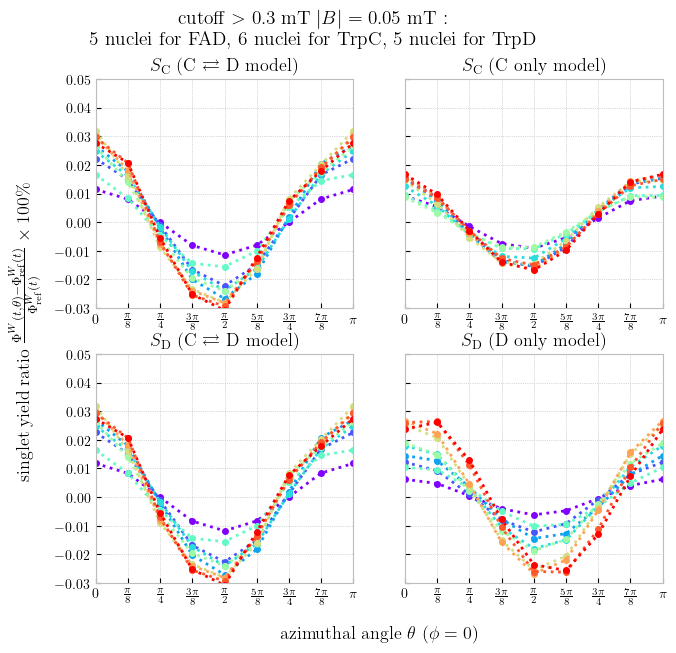

/tmp/ipykernel_6058/3838264376.py:67: RuntimeWarning: invalid value encountered in divide
  mfe_eq_C = (phi_eq_C_arr / phi_eq_C_ref[None, :] - 1.0) * 100.0
/tmp/ipykernel_6058/3838264376.py:68: RuntimeWarning: invalid value encountered in divide
  mfe_eq_D = (phi_eq_D_arr / phi_eq_D_ref[None, :] - 1.0) * 100.0
/tmp/ipykernel_6058/3838264376.py:69: RuntimeWarning: invalid value encountered in divide
  mfe_C    = (phi_C_arr    / phi_C_ref[None, :]    - 1.0) * 100.0
/tmp/ipykernel_6058/3838264376.py:70: RuntimeWarning: invalid value encountered in divide
  mfe_D    = (phi_D_arr    / phi_D_ref[None, :]    - 1.0) * 100.0


<Figure size 640x480 with 0 Axes>

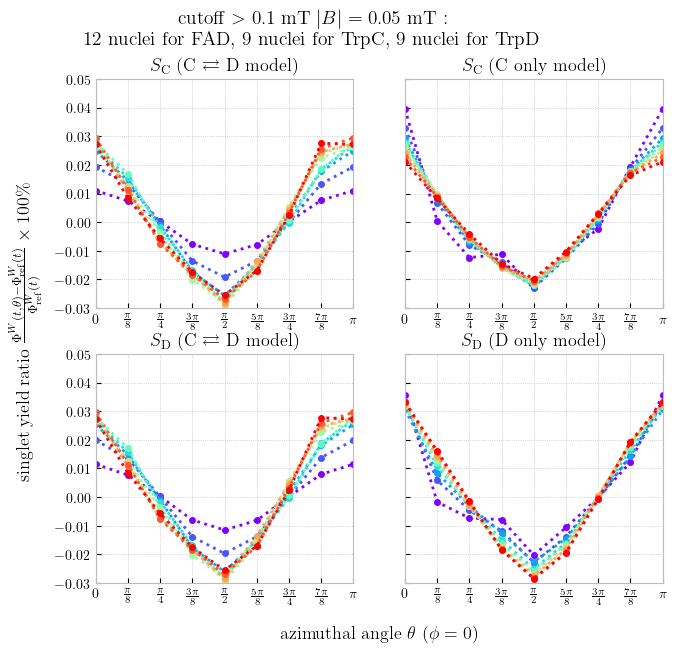

In [6]:
# cutoff, ele_site = 1.0, 0
# plot_aiso_mfe(cutoff, ele_site)
#cutoff, ele_site, ele_site_C, ele_site_D = 0.5, 3, 1, 1
#plot_aiso_mfe(cutoff, ele_site, ele_site_C, ele_site_D, show_xlabel=True)
# cutoff, ele_site, ele_site_C, ele_site_D = 0.3, 5, 5, 5
# plot_aiso_mfe(cutoff, ele_site, ele_site_C, ele_site_D, xlim=(0.0, 20.0), dn=1)
cutoff, ele_site, ele_site_C, ele_site_D = 0.3, 7, 6, 6
plot_aiso_mfe(
    cutoff,
    ele_site,
    ele_site_C,
    ele_site_D,
    ylim=(-0.03, 0.05),
    show_legend=False,
)
# cutoff, ele_site, ele_site_C, ele_site_D = 0.1, 12, 12, 12
# plot_aiso_mfe(cutoff, ele_site, ele_site_C, ele_site_D, xlim=(0.0, 20.0), dn=1)
cutoff, ele_site, ele_site_C, ele_site_D = 0.1, 13, 16, 16
plot_aiso_mfe(
    cutoff, ele_site, ele_site_C, ele_site_D, ylim=(-0.03, 0.05), show_legend=False
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

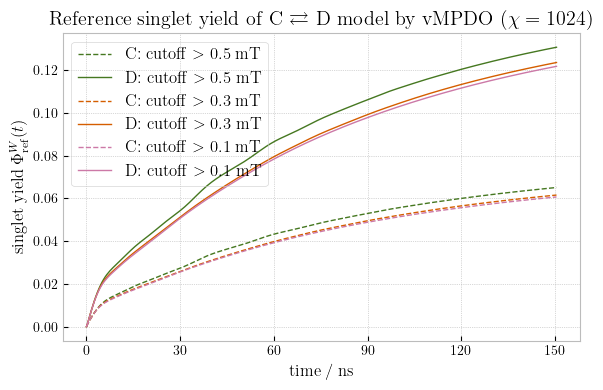

In [7]:
def plot_ref(
    cutoffs, ele_sites, show_ylabel=True, show_legend=True, xlim=None, ylim=None, dn=2
):
    plt.clf()
    fig = plt.figure(figsize=(6, 4))
    ls = [":", "-.", "--", "-"]
    m = 1024
    B = 0.05
    for i, (cutoff, ele_site) in enumerate(zip(cutoffs, ele_sites, strict=True)):
        phiS_C_refs = []
        phiS_D_refs = []
        for angle in range(8):
            jobname = f"theta/aiso_chi{m}_cutoff{cutoff}_eq_B{B}_angle{angle}pi_over_8_n4_arnoldi_prop"
            try:
                data = read_nc(f"{jobname}/reduced_density.nc", [(ele_site,)])
            except FileNotFoundError:
                continue

            time_data_μs = data["time"] * SCALE * 1e06 / units.au_in_fs
            dm = data[(ele_site,)]
            # time_data_μs, dm_eq, dm_C, dm_D = get_time_dm(m, d, cutoff, ele_site, ele_site_C=ele_site, ele_site_D=ele_site)
            dt = time_data_μs[1] - time_data_μs[0]

            # phiT_C_ref = np.cumsum((dm[:, 0, 0].real + dm[:, 1, 1].real + dm[:, 3, 3].real)) * kf_dict[(0,1)] * 1e-06 * dt
            phiS_C_refs.append(
                cumulative_population(time_data_μs, dm[:, 2].real)
                * kf_dict[(0, 1)]
                * 1e-06
            )
            # phiT_D_ref = np.cumsum((dm[:, 4, 4].real + dm[:, 5, 5].real + dm[:, 7, 7].real)) * kf_dict[(0,2)] * 1e-06 * dt
            phiS_D_refs.append(
                cumulative_population(time_data_μs, dm[:, 6].real)
                * kf_dict[(0, 2)]
                * 1e-06
            )

        phiS_C_ref = np.mean(phiS_C_refs, axis=0)
        phiS_D_ref = np.mean(phiS_D_refs, axis=0)

        plt.plot(
            time_data_μs[::dn] * 1000,
            phiS_C_ref[::dn],
            label=r"C: " + r"$\mathrm{cutoff} >" + f" {cutoff} {mT}$",
            ls=ls[-2],
            lw=1.0,
            color=colors[i + 3],
            #marker="o",
            markevery=20 // dn,
            markersize=5,
        )
        plt.plot(
            time_data_μs[::dn] * 1000,
            phiS_D_ref[::dn],
            label=r"D: " + r"$\mathrm{cutoff} >" + f" {cutoff} {mT}$",
            ls=ls[-1],
            lw=1.0,
            color=colors[i + 3],
            #marker="x",
            markevery=20 // dn,
            markersize=7,
        )

    # plt.title(r"$k_{\mathrm{D}\to \mathrm{C}} = $ " + f"${kDC/1e+09:.0f}$ {nsinv} " + r"$k_{\mathrm{C}\to \mathrm{D}} = $ " + f"${kCD/1e+09:.0f}$ {nsinv} \n"
    #          f"$|B|={B0} {mT}$ "+ r"$\frac{1}{3}\mathrm{Tr}|A| >"+f" {cutoff} {mT}$")
    plt.title(r"Reference singlet yield of C $\rightleftarrows$ D model by vMPDO ($\chi=1024$)")
    plt.xlabel(r"$\mathrm{time\;/\;ns}$")
    if show_ylabel:
        # plt.ylabel(r"$\Phi_T(t)=\int_0^\tau dt \left(k_f^C P_T^C(t) + k_f^D P_T^D(t) \right)$")
        plt.ylabel(r"$\mathrm{singlet\;yield\;}$" + r"$ \Phi_{\mathrm{ref}}^W(t)$")
    if show_legend:
        plt.legend(fontsize=12, ncol=1)#, loc="upper left", bbox_to_anchor=(1.01, 1))
    if xlim is None:
        # plt.xlim(0.0, 0.15)
        plt.xticks([0, 30, 60, 90, 120, 150])
        fname = f"phi_ref_cutoff{cutoff}_chi{m}.eps"
    else:
        plt.xlim(*xlim)
        fname = f"phi_ref_cutoff{cutoff}_chi{m}_t{xlim[0]}to{xlim[1]}.eps"
    if ylim is not None:
        plt.ylim(*ylim)
    plt.grid(ls=":")
    plt.tight_layout()
    plt.savefig(fname, bbox_inches="tight")
    plt.show()


cutoffs = [0.5, 0.3, 0.1]
ele_sites = [3, 7, 13]
plot_ref(cutoffs, ele_sites)

/tmp/ipykernel_6058/374773627.py:86: RuntimeWarning: invalid value encountered in divide
  mfe_eq_C = (phi_eq_C_arr / phi_eq_C_ref[None, :] - 1.0) * 100.0
/tmp/ipykernel_6058/374773627.py:87: RuntimeWarning: invalid value encountered in divide
  mfe_eq_D = (phi_eq_D_arr / phi_eq_D_ref[None, :] - 1.0) * 100.0
/tmp/ipykernel_6058/374773627.py:88: RuntimeWarning: invalid value encountered in divide
  mfe_C    = (phi_C_arr    / phi_C_ref[None, :]    - 1.0) * 100.0
/tmp/ipykernel_6058/374773627.py:89: RuntimeWarning: invalid value encountered in divide
  mfe_D    = (phi_D_arr    / phi_D_ref[None, :]    - 1.0) * 100.0


<Figure size 640x480 with 0 Axes>

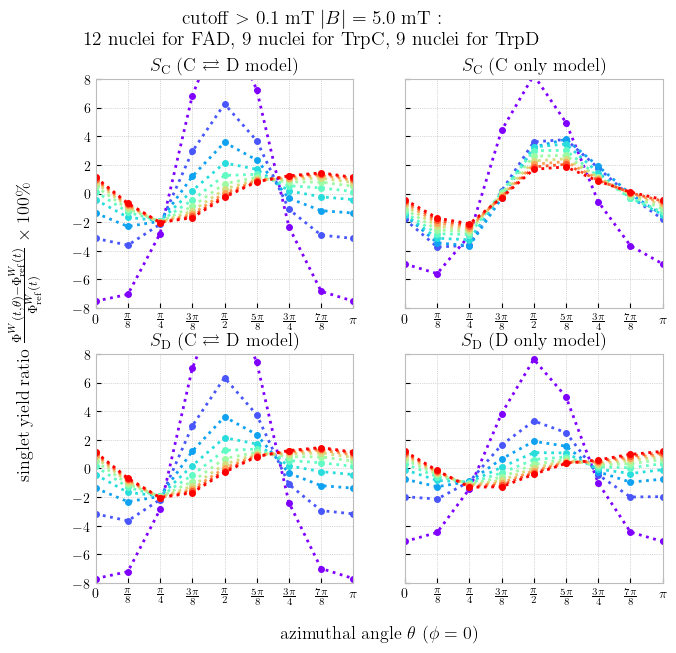

In [8]:
def get_time_dm_B(m, angle, cutoff, ele_site, ele_site_C, ele_site_D):
    B = 5.0
    jobname_eq = f"theta/aiso_chi{m}_cutoff{cutoff}_eq_B{B}_angle{angle}pi_over_8_n4_arnoldi_prop"
    jobname_C  = f"theta/aiso_chi{m}_cutoff{cutoff}_C_B{B}_angle{angle}pi_over_8_prop"
    jobname_D  = f"theta/aiso_chi{m}_cutoff{cutoff}_D_B{B}_angle{angle}pi_over_8_prop"

    try:
        data_eq = read_nc(f"{jobname_eq}/reduced_density.nc", [(ele_site, )])
        data_C = read_nc(f"{jobname_C}/reduced_density.nc", [(ele_site_C, )])
        data_D = read_nc(f"{jobname_D}/reduced_density.nc", [(ele_site_D, )])
    except FileNotFoundError:
        raise
    time_data_μs_eq = data_eq["time"] * SCALE * 1e06 / units.au_in_fs
    dm_eq = data_eq[(ele_site,)]
    time_data_μs_C = data_C["time"] * SCALE * 1e06 / units.au_in_fs
    dm_C = data_C[(ele_site_C,)]
    dm_D = data_D[(ele_site_D,)]
    return time_data_μs_eq, dm_eq, time_data_μs_C, dm_C, dm_D

def plot_aiso_mfe_B(
    cutoff,
    ele_site,
    ele_site_C,
    ele_site_D,
    show_xlabel=True,
    show_ylabel=True,
    show_legend=True,
    xlim=None,
    ylim=None,
    dn=15,
):
    """
    figure: 4 subplots [eq(C only), C only, eq(D only), D only]
    x: angle in [0, π/8, ..., π]  (θ)
    y: MFE (%) = (Phi(θ) - Phi_ref) / Phi_ref * 100
    legend: time series (e.g., 30 ns, 60 ns, ..., 390 ns) colored by rainbow gradation
    """
    import matplotlib as mpl
    import numpy as np
    import matplotlib.pyplot as plt

    # angles: 0..8 → 0, π/8, ..., π
    angle_idx = np.arange(0, 9)
    angle_values = angle_idx * (np.pi / 8.0)

    # 1) Gather Φ(t; θ) for each model across all angles (exclude π because = 0)
    phi_eq_C_list, phi_eq_D_list, phi_C_list, phi_D_list = [], [], [], []
    time_data_ref_eq = None
    time_data_ref_CD = None

    for angle in angle_idx[:-1]:
        time_data_μs_eq, dm_eq, time_data_μs_CD, dm_C, dm_D = get_time_dm_B(
            m, angle, cutoff, ele_site, ele_site_C, ele_site_D
        )
        if time_data_ref_eq is None:
            time_data_ref_eq = time_data_μs_eq  # shared across angles
            time_data_ref_CD = time_data_μs_CD  # shared across angles

        phi_eq_C = cumulative_population(time_data_μs_eq, dm_eq[:, 2].real) * kf_dict[(0, 1)] * 1e-06
        phi_eq_D = cumulative_population(time_data_μs_eq, dm_eq[:, 6].real) * kf_dict[(0, 2)] * 1e-06
        phi_D    = cumulative_population(time_data_μs_CD, dm_D[:, 2].real)  * kf_dict[(0, 2)] * 1e-06

        try:
            phi_C    = cumulative_population(time_data_μs_CD, dm_C[:, 2].real)  * kf_dict[(0, 1)] * 1e-06
        except:
            print(angle, m, cutoff, dm_C, time_data_μs_CD)
        
        phi_eq_C_list.append(phi_eq_C)
        phi_eq_D_list.append(phi_eq_D)
        phi_C_list.append(phi_C)
        phi_D_list.append(phi_D)

    # Stack to arrays: (n_angles, n_time)
    phi_eq_C_arr = np.asarray(phi_eq_C_list)
    phi_eq_D_arr = np.asarray(phi_eq_D_list)
    phi_C_arr    = np.asarray(phi_C_list)
    phi_D_arr    = np.asarray(phi_D_list)

    # 2) Reference (mean over angles), per model
    phi_eq_C_ref = np.mean(phi_eq_C_arr, axis=0)
    phi_eq_D_ref = np.mean(phi_eq_D_arr, axis=0)
    phi_C_ref    = np.mean(phi_C_arr,    axis=0)
    phi_D_ref    = np.mean(phi_D_arr,    axis=0)

    # 3) MFE (%, set t=0 to 0)
    mfe_eq_C = (phi_eq_C_arr / phi_eq_C_ref[None, :] - 1.0) * 100.0
    mfe_eq_D = (phi_eq_D_arr / phi_eq_D_ref[None, :] - 1.0) * 100.0
    mfe_C    = (phi_C_arr    / phi_C_ref[None, :]    - 1.0) * 100.0
    mfe_D    = (phi_D_arr    / phi_D_ref[None, :]    - 1.0) * 100.0
    for arr in (mfe_eq_C, mfe_eq_D, mfe_C, mfe_D):
        arr[:, 0] = 0.0

    # Append angle π row (= angle 0) to close the loop
    mfe_eq_C = np.vstack([mfe_eq_C, mfe_eq_C[0, :]])
    mfe_eq_D = np.vstack([mfe_eq_D, mfe_eq_D[0, :]])
    mfe_C    = np.vstack([mfe_C,    mfe_C[0, :]])
    mfe_D    = np.vstack([mfe_D,    mfe_D[0, :]])

    # 4) Plot: x=θ, legend=time (rainbow gradation)
    plt.clf()
    fig, axs = plt.subplots(2, 2, figsize=(7, 7), sharey=True)
    axs = axs.flatten()

    # time indices for plotting/legend
    time_idxs_eq = np.arange(4*dn, 4*dn * 11, 4*dn)
    time_idxs_CD = np.arange(1*dn, 1*dn * 11, 1*dn)
    times_ns_eq = time_data_ref_eq[time_idxs_eq] * 1000.0  # μs → ns
    times_ns_CD = time_data_ref_CD[time_idxs_CD] * 1000.0  # μs → ns

    panels = [
        (mfe_eq_C, r"$S_\mathrm{C}$ (C $\rightleftarrows$ D model)", ":", "o", time_idxs_eq, times_ns_eq),
        (mfe_C,    r"$S_\mathrm{C}$ (C only model)",      ":", "o", time_idxs_CD, times_ns_CD),
        (mfe_eq_D, r"$S_\mathrm{D}$ (C $\rightleftarrows$ D model)", ":", "o", time_idxs_eq, times_ns_eq),
        (mfe_D,    r"$S_\mathrm{D}$ (D only model)",      ":", "o", time_idxs_CD, times_ns_CD),
    ]
    # Rainbow gradation across time
    cmap = plt.get_cmap("rainbow")
    norm = mpl.colors.Normalize(vmin=times_ns_eq.min(), vmax=times_ns_eq.max())
    time_colors = cmap(norm(times_ns_eq))  # one color per time curve

    # θ ticks: 0, π/8, …, π
    if xlim is None:
        xticks = angle_values
        xtick_labels = [r"$0$", r"$\frac{\pi}{8}$",  r"$\frac{\pi}{4}$", r"$\frac{3\pi}{8}$", r"$\frac{\pi}{2}$",
                        r"$\frac{5\pi}{8}$", r"$\frac{3\pi}{4}$", r"$\frac{7\pi}{8}$", r"$\pi$"]

    for ax_i, (ax, (mfe_arr, title, ls, marker, time_idxs, times_ns)) in enumerate(zip(axs, panels)):
        for j, t_idx in enumerate(time_idxs):
            ax.plot(
                angle_values,
                mfe_arr[:, t_idx],
                ls=ls,
                marker=marker,
                color=time_colors[j],
                label=(f"{times_ns[j]:.0f} ns" if ax_i == 0 else None),  # only label in first panel
                markevery=1,
                markersize=4,
            )
        ax.set_title(title, fontsize=13)
        if xlim is None:
            ax.set_xlim(0.0, np.pi)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xtick_labels, fontsize=10)
        else:
            ax.set_xlim(*xlim)
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.grid(ls=":")


    # Legend: right side, single column (use handles from first panel)
    # --- legend (right side) ---
    if show_legend:
        handles, labels = axs[0].get_legend_handles_labels()
        # leave space for legend on the right
        fig.subplots_adjust(left=0.14, bottom=0.16, top=0.88, right=0.78)
        fig.legend(
            handles, labels,
            loc="center left", bbox_to_anchor=(0.80, 0.5),
            ncol=1, fontsize=10, frameon=True,
        )
    else:
        fig.subplots_adjust(left=0.14, bottom=0.16, top=0.88, right=0.95)

    # --- compute grid bbox and place shared labels + tighter title ---
    # need a draw to finalize positions
    fig.canvas.draw()
    bboxes = [ax.get_position() for ax in axs]
    left   = min(bb.x0 for bb in bboxes)
    right  = max(bb.x1 for bb in bboxes)
    bottom = min(bb.y0 for bb in bboxes)
    top    = max(bb.y1 for bb in bboxes)

    grid_x_center = (left + right) / 2.0
    grid_y_center = (bottom + top) / 2.0

    # shared x/y labels centered on the grid area
    if show_xlabel:
        fig.text(grid_x_center, bottom - 0.06, r"azimuthal angle $\theta$ ($\phi=0$)",
                 ha="center", va="top", fontsize=13)
    if show_ylabel:
        fig.text(left - 0.10, grid_y_center,
                 (r"$\mathrm{singlet\;yield\;ratio}\; "
                  r"\frac{\Phi^W(t, \theta)-\Phi_{\mathrm{ref}}^W(t)}{\Phi_{\mathrm{ref}}^W(t)} \times 100\%$"),
                 ha="center", va="center", rotation=90, fontsize=13)

    # move title closer to the grid (just above the top of subplots)
    if cutoff == 0.5:
        Nf, Nc, Nd = 1, 3, 3
    elif cutoff == 0.3:
        Nf, Nc, Nd = 5, 6, 5
    elif cutoff == 0.1:
        Nf, Nc, Nd = 12, 9, 9
    else:
        raise ValueError
    plt.suptitle(r"$\mathrm{cutoff} > " + f"{cutoff} {mT}\\; |B| = 5.0 {mT}$ : \n {Nf} {"nucleus" if Nf==1 else "nuclei"} for FAD, {Nc} nuclei for TrpC, {Nd} nuclei for TrpD",
                 fontsize=14, y=min(top + 0.10, 1.00), x=0.45)

    # no further tight_layout here; we've positioned everything explicitly
    fname = f"phi_cutoff{cutoff}_chi{m}_theta_4subplots_B5.0.eps"
    plt.savefig(fname, bbox_inches="tight")
    plt.show()

cutoff, ele_site, ele_site_C, ele_site_D = 0.1, 13, 16, 16
plot_aiso_mfe_B(
    cutoff, ele_site, ele_site_C, ele_site_D, ylim=(-8.0, 8.0), show_legend=False
)

/tmp/ipykernel_6058/2587791528.py:93: RuntimeWarning: invalid value encountered in divide
  mfe_eq_C = (phi_eq_C_arr / phi_eq_C_ref[None, :] - 1.0) * 100.0
/tmp/ipykernel_6058/2587791528.py:94: RuntimeWarning: invalid value encountered in divide
  mfe_eq_D = (phi_eq_D_arr / phi_eq_D_ref[None, :] - 1.0) * 100.0
/tmp/ipykernel_6058/2587791528.py:95: RuntimeWarning: invalid value encountered in divide
  mfe_C    = (phi_C_arr    / phi_C_ref[None, :]    - 1.0) * 100.0
/tmp/ipykernel_6058/2587791528.py:96: RuntimeWarning: invalid value encountered in divide
  mfe_D    = (phi_D_arr    / phi_D_ref[None, :]    - 1.0) * 100.0


<Figure size 640x480 with 0 Axes>

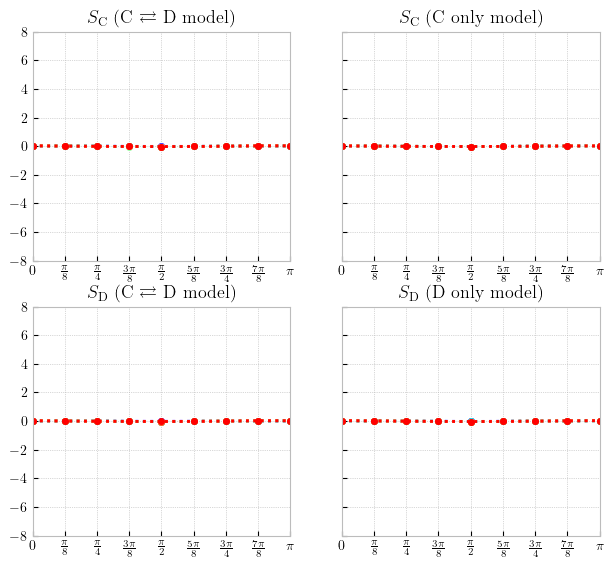

In [9]:
# Generate Legend Only file

def get_time_dm_B(m, angle, cutoff, ele_site, ele_site_C, ele_site_D, B=0.05):
    jobname_eq = f"theta/aiso_chi{m}_cutoff{cutoff}_eq_B{B}_angle{angle}pi_over_8_n4_arnoldi_prop"
    jobname_C  = f"theta/aiso_chi{m}_cutoff{cutoff}_C_B{B}_angle{angle}pi_over_8_prop"
    jobname_D  = f"theta/aiso_chi{m}_cutoff{cutoff}_D_B{B}_angle{angle}pi_over_8_prop"

    try:
        data_eq = read_nc(f"{jobname_eq}/reduced_density.nc", [(ele_site, )])
        data_C  = read_nc(f"{jobname_C}/reduced_density.nc",  [(ele_site_C, )])
        data_D  = read_nc(f"{jobname_D}/reduced_density.nc",  [(ele_site_D, )])
    except FileNotFoundError:
        raise

    time_data_μs_eq = data_eq["time"] * SCALE * 1e06 / units.au_in_fs
    dm_eq = data_eq[(ele_site,)]
    time_data_μs_C  = data_C["time"]  * SCALE * 1e06 / units.au_in_fs
    dm_C = data_C[(ele_site_C,)]
    dm_D = data_D[(ele_site_D,)]
    return time_data_μs_eq, dm_eq, time_data_μs_C, dm_C, dm_D


def plot_aiso_mfe_B(
    #m,                  # <-- added
    cutoff,
    ele_site,
    ele_site_C,
    ele_site_D,
    #B=5.0,              # <-- added
    show_xlabel=True,
    show_ylabel=True,
    show_legend=True,   # show legend inside the figure (ignored if legend_outfile is set)
    xlim=None,
    ylim=None,
    dn=15,
    legend_outfile=None,        # <-- if set (e.g., "2.eps"), save a separate legend-only figure
    legend_ncol=1,              # columns in legend-only figure
):
    """
    figure: 4 subplots [eq(C only), C only, eq(D only), D only]
    x: angle in [0, π/8, ..., π]  (θ)
    y: MFE (%) = (Phi(θ) - Phi_ref) / Phi_ref * 100
    legend: time series (e.g., 30 ns, 60 ns, ..., 390 ns) colored by rainbow gradation
    """
    import matplotlib as mpl
    import numpy as np
    import matplotlib.pyplot as plt

    # Embed fonts nicely in EPS so text stays editable
    mpl.rcParams["ps.fonttype"] = 42
    mpl.rcParams["pdf.fonttype"] = 42

    # angles: 0..8 → 0, π/8, ..., π
    angle_idx = np.arange(0, 9)
    angle_values = angle_idx * (np.pi / 8.0)

    # 1) Gather Φ(t; θ) for each model across all angles (exclude π because = 0)
    phi_eq_C_list, phi_eq_D_list, phi_C_list, phi_D_list = [], [], [], []
    time_data_ref_eq = None
    time_data_ref_CD = None

    for angle in angle_idx[:-1]:
        time_data_μs_eq, dm_eq, time_data_μs_CD, dm_C, dm_D = get_time_dm_B(
            m, angle, cutoff, ele_site, ele_site_C, ele_site_D,
        )
        if time_data_ref_eq is None:
            time_data_ref_eq = time_data_μs_eq  # shared across angles
            time_data_ref_CD = time_data_μs_CD  # shared across angles

        phi_eq_C = cumulative_population(time_data_μs_eq, dm_eq[:, 2].real) * kf_dict[(0, 1)] * 1e-06
        phi_eq_D = cumulative_population(time_data_μs_eq, dm_eq[:, 6].real) * kf_dict[(0, 2)] * 1e-06
        phi_D    = cumulative_population(time_data_μs_CD, dm_D[:, 2].real)  * kf_dict[(0, 2)] * 1e-06
        phi_C    = cumulative_population(time_data_μs_CD, dm_C[:, 2].real)  * kf_dict[(0, 1)] * 1e-06

        phi_eq_C_list.append(phi_eq_C)
        phi_eq_D_list.append(phi_eq_D)
        phi_C_list.append(phi_C)
        phi_D_list.append(phi_D)

    # Stack to arrays: (n_angles, n_time)
    phi_eq_C_arr = np.asarray(phi_eq_C_list)
    phi_eq_D_arr = np.asarray(phi_eq_D_list)
    phi_C_arr    = np.asarray(phi_C_list)
    phi_D_arr    = np.asarray(phi_D_list)

    # 2) Reference (mean over angles), per model
    phi_eq_C_ref = np.mean(phi_eq_C_arr, axis=0)
    phi_eq_D_ref = np.mean(phi_eq_D_arr, axis=0)
    phi_C_ref    = np.mean(phi_C_arr,    axis=0)
    phi_D_ref    = np.mean(phi_D_arr,    axis=0)

    # 3) MFE (%, set t=0 to 0)
    mfe_eq_C = (phi_eq_C_arr / phi_eq_C_ref[None, :] - 1.0) * 100.0
    mfe_eq_D = (phi_eq_D_arr / phi_eq_D_ref[None, :] - 1.0) * 100.0
    mfe_C    = (phi_C_arr    / phi_C_ref[None, :]    - 1.0) * 100.0
    mfe_D    = (phi_D_arr    / phi_D_ref[None, :]    - 1.0) * 100.0
    for arr in (mfe_eq_C, mfe_eq_D, mfe_C, mfe_D):
        arr[:, 0] = 0.0

    # Append angle π row (= angle 0) to close the loop
    mfe_eq_C = np.vstack([mfe_eq_C, mfe_eq_C[0, :]])
    mfe_eq_D = np.vstack([mfe_eq_D, mfe_eq_D[0, :]])
    mfe_C    = np.vstack([mfe_C,    mfe_C[0, :]])
    mfe_D    = np.vstack([mfe_D,    mfe_D[0, :]])

    # 4) Plot: x=θ, legend=time (rainbow gradation)
    plt.clf()
    fig, axs = plt.subplots(2, 2, figsize=(7, 7), sharey=True)
    axs = axs.flatten()

    # time indices for plotting/legend
    time_idxs_eq = np.arange(4*dn, 4*dn * 11, 4*dn)
    time_idxs_CD = np.arange(1*dn, 1*dn * 11, 1*dn)
    times_ns_eq = time_data_ref_eq[time_idxs_eq] * 1000.0  # μs → ns
    times_ns_CD = time_data_ref_CD[time_idxs_CD] * 1000.0  # μs → ns

    panels = [
        (mfe_eq_C, r"$S_\mathrm{C}$ (C $\rightleftarrows$ D model)", ":", "o", time_idxs_eq, times_ns_eq),
        (mfe_C,    r"$S_\mathrm{C}$ (C only model)",                 ":", "o", time_idxs_CD, times_ns_CD),
        (mfe_eq_D, r"$S_\mathrm{D}$ (C $\rightleftarrows$ D model)", ":", "o", time_idxs_eq, times_ns_eq),
        (mfe_D,    r"$S_\mathrm{D}$ (D only model)",                 ":", "o", time_idxs_CD, times_ns_CD),
    ]

    # Rainbow gradation across time (use eq time range for consistent colors)
    cmap = plt.get_cmap("rainbow")
    norm = mpl.colors.Normalize(vmin=float(times_ns_eq.min()), vmax=float(times_ns_eq.max()))
    time_colors = cmap(norm(times_ns_eq))  # one color per time curve

    # θ ticks: 0, π/8, …, π
    if xlim is None:
        xticks = angle_values
        xtick_labels = [r"$0$", r"$\frac{\pi}{8}$",  r"$\frac{\pi}{4}$", r"$\frac{3\pi}{8}$", r"$\frac{\pi}{2}$",
                        r"$\frac{5\pi}{8}$", r"$\frac{3\pi}{4}$", r"$\frac{7\pi}{8}$", r"$\pi$"]

    for ax_i, (ax, (mfe_arr, title, ls, marker, time_idxs, times_ns)) in enumerate(zip(axs, panels)):
        for j, t_idx in enumerate(time_idxs):
            ax.plot(
                angle_values,
                mfe_arr[:, t_idx],
                ls=ls,
                marker=marker,
                color=time_colors[j],
                label=(f"{times_ns[j]:.0f} ns" if ax_i == 0 else None),  # only label in first panel
                markevery=1,
                markersize=4,
            )
        ax.set_title(title, fontsize=13)
        if xlim is None:
            ax.set_xlim(0.0, np.pi)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xtick_labels, fontsize=10)
        else:
            ax.set_xlim(*xlim)
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.grid(ls=":")

    # Layout & legend handling
    if legend_outfile:
        # no in-figure legend; use full width
        fig.subplots_adjust(left=0.14, bottom=0.16, top=0.88, right=0.95)
    elif show_legend:
        handles, labels = axs[0].get_legend_handles_labels()
        fig.subplots_adjust(left=0.14, bottom=0.16, top=0.88, right=0.78)
        fig.legend(
            handles, labels,
            loc="center left", bbox_to_anchor=(0.80, 0.5),
            ncol=1, fontsize=10, frameon=True,
        )
    else:
        fig.subplots_adjust(left=0.14, bottom=0.16, top=0.88, right=0.95)


    handles, labels = axs[0].get_legend_handles_labels()
    fig_leg = plt.figure(figsize=(8, 1.8))
    fig_leg.legend(
            handles, labels,
            loc="center",
            ncol=legend_ncol,
            frameon=False,
            handlelength=2.2,
            columnspacing=1.5,
            labelspacing=0.8,
            fontsize=16,
        )
    fig_leg.savefig(legend_outfile, bbox_inches="tight")
    plt.close(fig_leg)
    plt.show()
cutoff, ele_site, ele_site_C, ele_site_D = 0.1, 13, 16, 16
plot_aiso_mfe_B(
    cutoff, ele_site, ele_site_C, ele_site_D, ylim=(-8.0, 8.0), legend_outfile="legend.eps"
)